In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import pickle

sns.set_context("talk")
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr


from loren_frank_data_processing import (
    get_multiunit_dataframe,
    get_multiunit_dataframe2,
)

from src.load_data import load_data
from src.parameters import ANIMALS
from ZilongCode.utils import (
    get_steps,
    get_diffusion_exponent,
)

### 1, plot theta sweep example

In [31]:
epoch_key = ("bon", 8, 4)
data = load_data(epoch_key)

Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, using distance from well to segment trials
Failed to load file: /media/zilong/4TB Storage HDD/ReplayTrajectoryAnalysis/Raw-Data/Bond/bonDIO08.mat
No DIO file found, inferring correct inbound/outbound from task rules


In [32]:
datafolder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ThetaSweepTrajectories"
)

animal, day, epoch = epoch_key
# load the classifier results
cv_classifier_clusterless_results = xr.open_dataset(
    os.path.join(
        datafolder,
        f"{animal}_{day:02d}_{epoch:02d}_cv_classifier_clusterless_results.nc",
    )
)

# get all time slice
t = data["position_info"].index / np.timedelta64(1, "s")

In [36]:
# load multiunit times
multiunit_times = [
    get_multiunit_dataframe(tetrode_key, ANIMALS)
    for tetrode_key in data["tetrode_info"].index
]
if multiunit_times[0] is None:
    multiunit_times = [
        get_multiunit_dataframe2(tetrode_key, ANIMALS)
        for tetrode_key in data["tetrode_info"].index
    ]
# reset index in multiunit_times to seconds and replace the original multiunit_times
for i in range(len(multiunit_times)):
    indext_i = multiunit_times[i].index / np.timedelta64(1, "s")
    multiunit_times[i].index = indext_i

In [103]:
def plot_theta_examples(time_slice_sweep, t, multiunit_times, results, data):

    """
    Modified from https://github.com/edeno/replicate_kenny_analysis/blob/master/notebooks/Bond_day8_Epoch4.ipynb
    by Zilong, 30/08/2023
    plor the theta sweeps in time_slice
    Input:
        time_slice: the time slice to plot
        t: the time index
        results: the results from the model
        data: the data from the model
        add_zero_phase_index: whether to add the zero phase index
    Output:
        a plot with 3 subplots
    """

    cmap = plt.cm.inferno
    cmap.set_bad("white", alpha=1.0)
    labelsize = 10
    ticksize = 8
    # set background color to white
    sns.set_style("white")

    fig = plt.figure(figsize=(2.5, 3), dpi=300)

    gs = gridspec.GridSpec(4, 1, height_ratios=[0.5, 1, 3, 1])

    ax1 = plt.subplot(gs[0, 0])

    ind = 0
    lfp = (
        data["lfps"]
        .reset_index(drop=True)
        .set_index(data["lfps"].index / np.timedelta64(1, "s"))
    )

    # plot as curve, not fill
    ax1.plot(
        lfp.loc[time_slice_sweep].index.values,
        lfp.loc[time_slice_sweep].iloc[:, ind].values.squeeze(),
        color="grey",
        linewidth=1,
    )
    ax1.set_ylabel("LFP")

    # remove xticks
    ax1.set_xticks([])
    # remove y ticks
    ax1.set_yticks([])

    # ax2
    ax2 = plt.subplot(gs[1, 0])

    n_tetrodes = len(multiunit_times)

    # eventplot with small dot
    ax2.eventplot(
        [multiunit.loc[time_slice_sweep].index for multiunit in multiunit_times],
        color="black",
        clip_on=False,
        linewidths=0.5,
    )

    ax2.set_yticks((1, n_tetrodes))
    # move the y ticks to right
    ax2.yaxis.tick_right()
    # remove y tick bars
    ax2.tick_params(axis="y", length=0)
    ax2.set_ylim((1, n_tetrodes))
    ax2.set_ylabel("Tet. id")
    ax2.set_xticks([])
    sns.despine(ax=ax2, offset=5)
    ax2.spines["bottom"].set_visible(False)

    # ax 3
    ax3 = plt.subplot(gs[2, 0])
    # plot
    results["acausal_posterior"].sum("state", skipna=False).sel(
        time=time_slice_sweep
    ).plot(
        x="time",
        y="position",
        robust=True,
        ax=ax3,
        cmap=cmap,
        vmin=0.0,
    )

    ax3.plot(
        data["position_info"].reset_index().set_index(t).loc[time_slice_sweep].index,
        data["position_info"]
        .reset_index()
        .set_index(t)
        .loc[time_slice_sweep]
        .linear_position,
        color="darkturquoise",
        linestyle="-",
        linewidth=2,
        alpha=1,
    )

    # remove all labels, ticks and spines in axi, as well as colorbars
    ax3.set_xlabel("")
    ax3.set_ylabel("")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_visible(False)
    ax3.spines["bottom"].set_visible(False)
    ax3.collections[0].colorbar.remove()

    # ax4
    ax4 = plt.subplot(gs[3, 0])
    results.mental_distance_from_actual_position.sel(time=time_slice_sweep).plot(
        x="time", ax=ax4, color="#F18D00", linewidth=1, alpha=0.8
    )
    # set y label as 'Offset' and x label empty
    ax4.set_ylabel("", fontsize=labelsize)
    ax4.set_xlabel("", fontsize=labelsize)
    # set ticks off
    ax4.set_yticks([0, 40])
    # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
    ax4.set_xticks(
        [np.round(time_slice_sweep.start, 1), np.round(time_slice_sweep.stop, 1)]
    )
    # tick labels without scientific notation
    ax4.ticklabel_format(useOffset=False, style="plain")
    # set tick font size as ticksize
    ax4.tick_params(labelsize=ticksize)

    # set x ticks with time_slice_sweep.start and time_slice_sweep.stop, keep one decimal
    ax4.set_xticks(
        [np.round(time_slice_sweep.start, 1), np.round(time_slice_sweep.stop, 1)]
    )

    # add ripple times to the plot as red bars on top of the LFP
    # first get the ripples time within the time slice
    for i in data["ripple_times"].index:
        # get the ripple time
        ripple_time = data["ripple_times"].iloc[i - 1]
        start_time = ripple_time.loc["start_time"] / np.timedelta64(1, "s")
        end_time = ripple_time.loc["end_time"] / np.timedelta64(1, "s")
        # if start_time and end_time are both in the time slice. then add the ripple to the plot
        # x range is start_time to end_time, y range is [0,300]
        if start_time > time_slice_sweep.start and end_time < time_slice_sweep.stop:
            ax3.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.6, lw=0
            )
            ax4.axvspan(
                start_time, end_time, ymin=0, ymax=1, color="grey", alpha=0.3, lw=0
            )

    # set ticks and spines
    all_axes = fig.get_axes()
    for ax in all_axes:
        ax.tick_params(labelsize=ticksize)
        ax.xaxis.label.set_size(labelsize)
        ax.yaxis.label.set_size(labelsize)
        # set axes off bottom left top and right
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim(time_slice_sweep.start - 0.05, time_slice_sweep.stop)
        ax.yaxis.set_label_coords(-0.2, 0.5)

    # add back ax4 bottom and left spines
    ax4.spines["bottom"].set_visible(True)
    ax4.spines["left"].set_visible(True)
    # set axis linewidth 1.0
    ax4.spines["bottom"].set_linewidth(1.0)
    ax4.spines["left"].set_linewidth(1.0)

    # align y labels of ax1 and ax2

    plt.tight_layout()

    # save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
    savedir = (
        "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
    )

    savename = "Fig5_theta_sweep_examples.pdf"
    plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

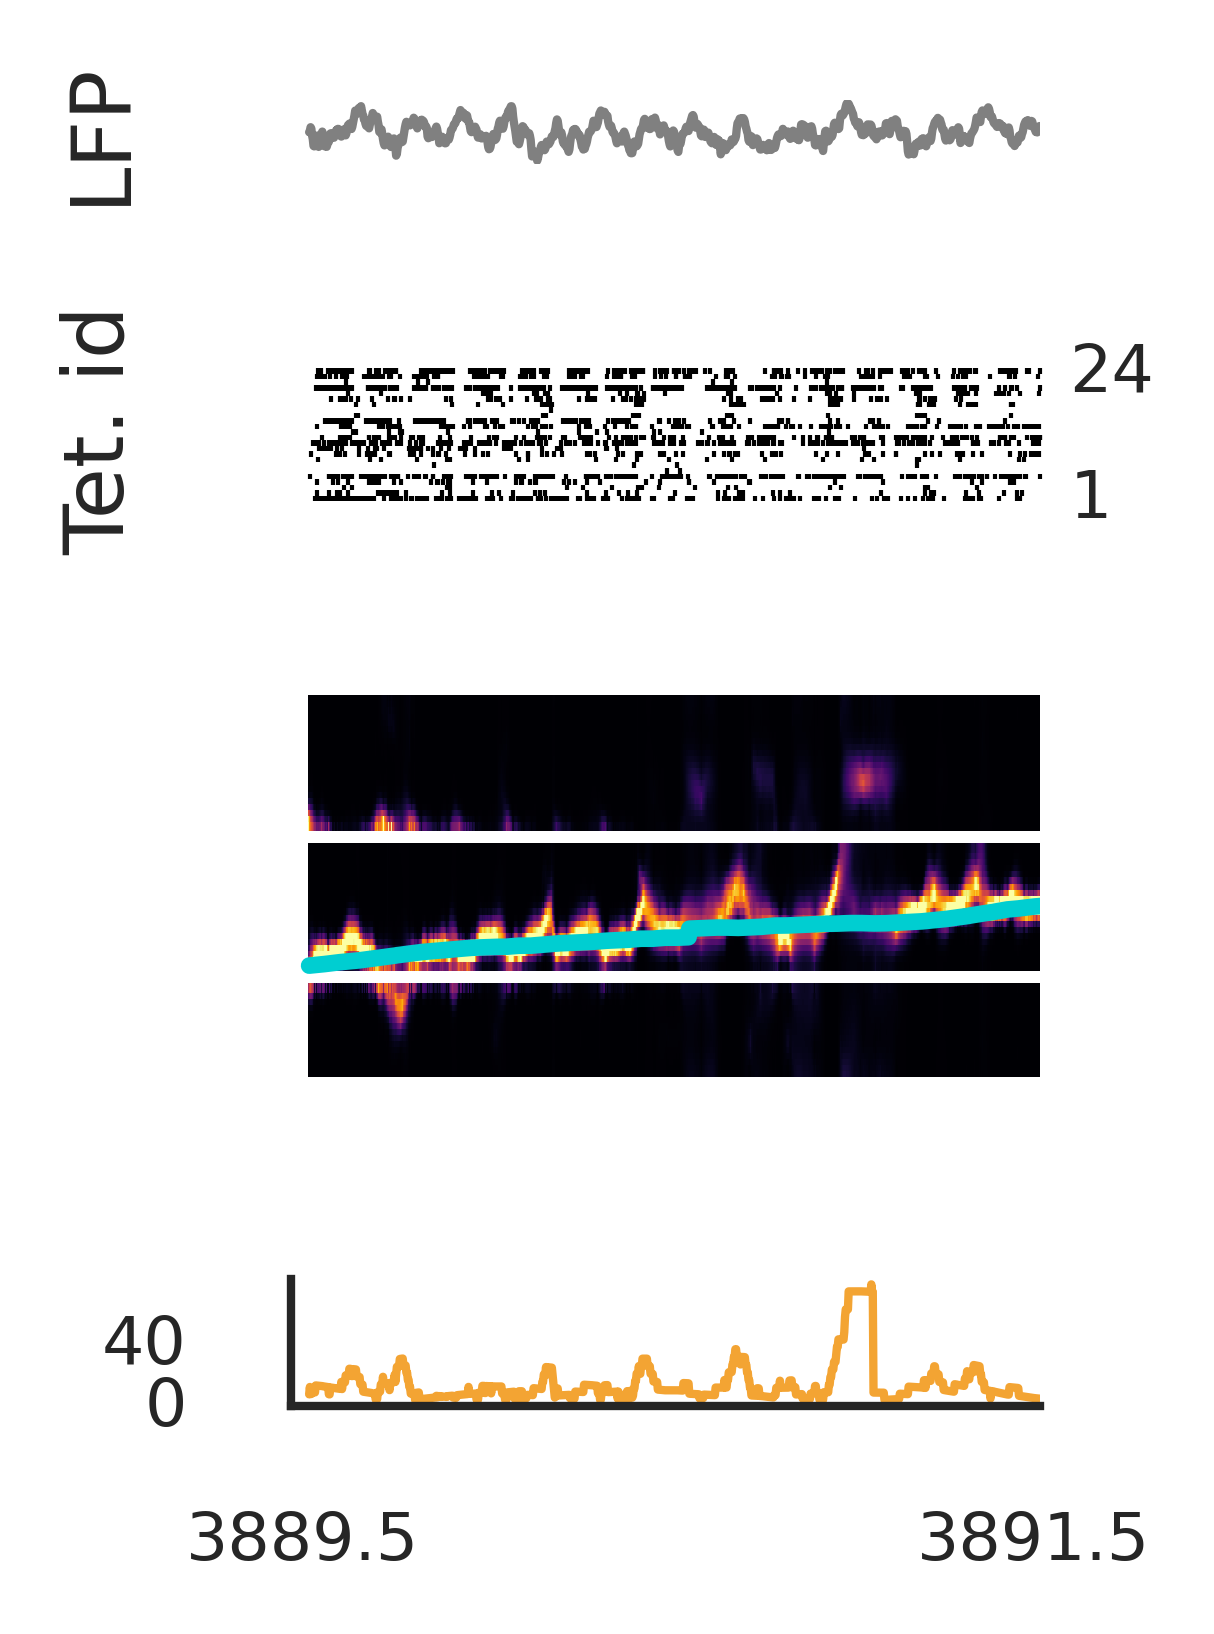

In [104]:
time_slice = slice(t.min(), t.max())  # 107-117
time_slice_sweep = slice(t.min() + 243.5, t.min() + 245.5)
plot_theta_examples(
    time_slice_sweep,
    t,
    multiunit_times,
    cv_classifier_clusterless_results,
    data,
)

### 2, plot sweep length vs diffusion exponent from model and experimental data, as well as the correlation with place field size

In [3]:
# geneerate shuffled replay trajectories by shuffle the value under the key 'replay_trajectory'
def position_shuffling(Replay_traj):
    """
    shuffle the replay trajectory by shuffling the decoded position under each key of Replay_traj
    Input:
        Replay_traj: the replay trajectory
    Output:
        Replay_traj_shuffled: the shuffled replay trajectory
    """
    Replay_traj_shuffled = Replay_traj.copy()
    for key in Replay_traj_shuffled.keys():
        Replay_traj_shuffled[key] = np.random.permutation(Replay_traj_shuffled[key])
    return Replay_traj_shuffled

In [4]:
# load all replay trajectory from computer
replay_folder = (
    "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/ReplayTrajectories"
)

# get all file with _traj.pkl
replay_files = [f for f in os.listdir(replay_folder) if f.endswith("_traj.pkl")]

# for each file, load the replay trajectory
all_exponent = []
all_exponent_shuffled = []
for replay_file in replay_files:
    # print("loading file: and calculate the diffusion exponent")
    print("load file: ", replay_file, " and calculate the diffusion exponent")
    with open(os.path.join(replay_folder, replay_file), "rb") as f:
        Replay_traj = pickle.load(f)
        exponent = get_diffusion_exponent(Replay_traj)
        all_exponent.append(exponent)

        # shuflle the replay trajectory
        Replay_traj_shuffled = position_shuffling(Replay_traj)
        exponent_shuffled = get_diffusion_exponent(Replay_traj_shuffled)
        all_exponent_shuffled.append(exponent_shuffled)

load file:  dav_07_07_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_06_traj.pkl  and calculate the diffusion exponent
load file:  Cor_02_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_07_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_05_06_traj.pkl  and calculate the diffusion exponent
load file:  gov_08_04_traj.pkl  and calculate the diffusion exponent
load file:  dud_06_02_traj.pkl  and calculate the diffusion exponent
load file:  bon_03_02_traj.pkl  and calculate the diffusion exponent
load file:  Cor_07_02_traj.pkl  and calculate the diffusion exponent
load file:  dav_07_03_traj.pkl  and calculate the diffusion exponent
load file:  fra_04_02_traj.pkl  and calculate the diffusion exponent
load file:  gov_10_02_traj.pkl  and calculate the diffusion exponent
load file:  con_01_04_traj.pkl  and calculate the diffusion exponent
load file:  dav_04_02_traj.pkl  and calculate the diffusion exponent
load file:  con_03_02_traj.pkl  an

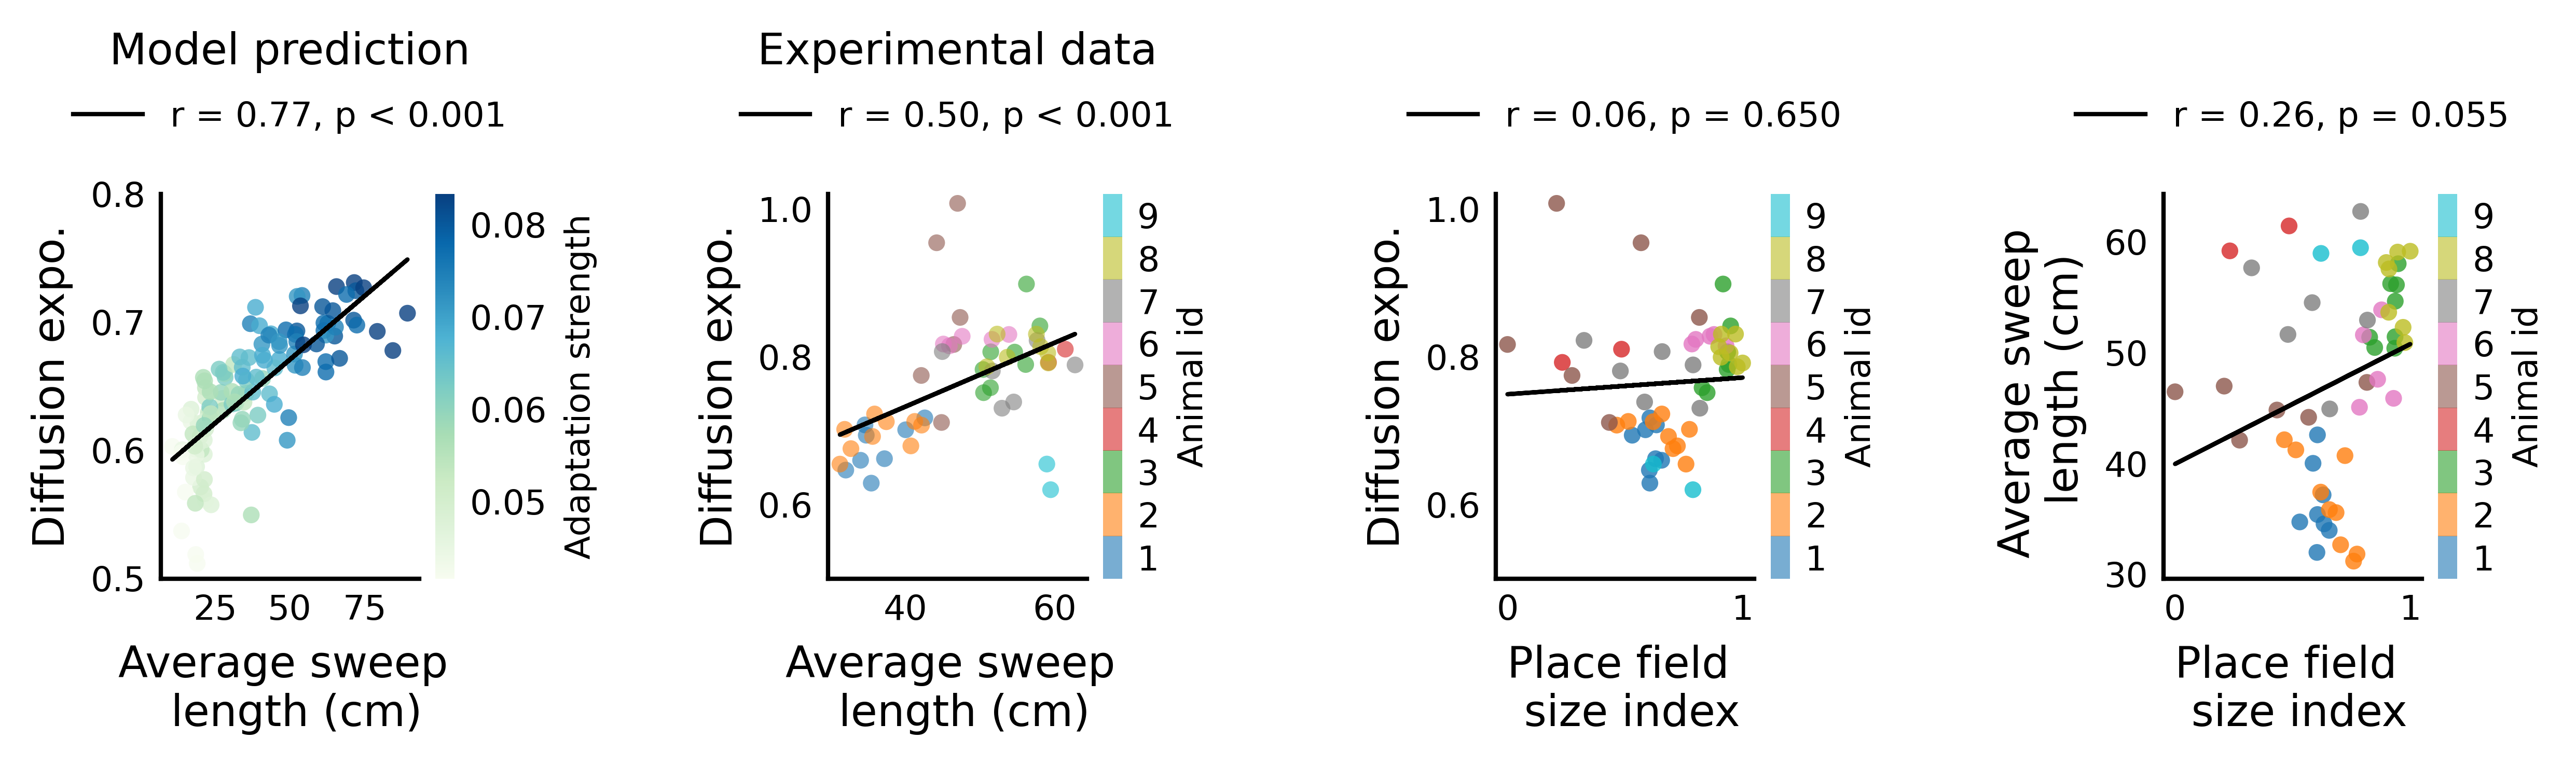

In [5]:
# load replay trajectory from the 'ReplayTrajectories'

animal, day, epoch = ("bon", 8, 4)
with open(
    os.path.join(replay_folder, f"{animal}_{day:02d}_{epoch:02d}_traj.pkl"), "rb"
) as f:
    Replay_traj = pickle.load(f)

all_timebins = np.arange(1, 20, 1)
all_avg_steps = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps.append(avg_step)

# get the slope of the log-log plot
slope, intercept = np.polyfit(np.log(all_timebins), np.log(all_avg_steps), 1)

# get shuffled replay trajectory
Replay_traj_shuffled = position_shuffling(Replay_traj)
all_avg_steps_shuffled = []
for timeb in all_timebins:
    all_steps = get_steps(Replay_traj_shuffled, timeb)
    # get the average step size for each time bin
    avg_step = np.mean(all_steps)
    all_avg_steps_shuffled.append(avg_step)

# get the slope of the log-log plot
slope_shuffled, intercept_shuffled = np.polyfit(
    np.log(all_timebins), np.log(all_avg_steps_shuffled), 1
)


fig = plt.figure(figsize=(8.6, 2.8), dpi=300)
gs = gridspec.GridSpec(1, 4)
labelsize = 10
ticksize = 8
realtraj_color = "#009FB9"

# ax 3
ax0 = plt.subplot(gs[0])

# load the data from the pickle file
import pickle

with open(
    "/home/zilong/Desktop/AdaptiveAttractorForSequences/PaperFigureCode/sweep_replay_correlation.pkl",
    "rb",
) as f:
    M, MeanSweep, MeanSweepAmp, DiffusionExp = pickle.load(f)
cmap_user = "GnBu"
# Create a colormap scalar map
norm = Normalize(vmin=np.min(M), vmax=np.max(M))
cmap = cm.get_cmap(cmap_user)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # An empty array to create the color mapping

simulation_nums = DiffusionExp.shape[0]
for i in range(simulation_nums):
    ax0.scatter(
        MeanSweepAmp[i, :],
        DiffusionExp[i, :],
        c=M,
        cmap=cmap_user,
        s=15,
        alpha=0.8,
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert MeanSweep and DiffusionExp from 2D array to 1D array
exp_np = DiffusionExp.flatten()
sweep_len_np = MeanSweepAmp.flatten()
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
if p < 0.001:
    ax0.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax0.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax0.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# Add a colorbar
cbar = plt.colorbar(sm, ax=ax0)
cbar.set_label("Adaptation strength", fontsize=ticksize)
# set colorbar box off
cbar.outline.set_visible(False)
# set colorbar ticks with fontsize ticksizes
cbar.ax.tick_params(labelsize=ticksize)

ax0.set_xlabel("Average sweep \n length (cm)", fontsize=labelsize)
ax0.set_ylabel("Diffusion expo.", fontsize=labelsize)
# ad title as 'Model prediction'
ax0.set_title("Model prediction", fontsize=labelsize, pad=30)
# change the xticks from meter to centermeter by times 100
ax0.set_xticks([0.25, 0.5, 0.75])
ax0.set_xticklabels([25, 50, 75])
# set y ticks
ax0.set_yticks([0.5, 0.6, 0.7, 0.8])

# ax1
ax1 = plt.subplot(gs[1])

# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open("../../Processed-Data/sweep_replay_correlation_realdata.pkl", "rb") as f:
    (
        animal_names,
        all_sweep_len_perday_concat,
        all_sweep_amp_perday_concat,
        all_sweep_ahead_perday_concat,
        all_sweep_behind_perday_concat,
        all_exponent_perday_concat,
        all_ave_activespeed_perday_concat,
    ) = pickle.load(f)

# get the color for each animal
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

# plot the real data
for name in animal_names:
    ax1.scatter(
        np.array(all_sweep_amp_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.6,
        color=color_dict[name],
        edgecolors="none",
    )

# add linear fit line to the plot using numpy.polyfit
# convert all_sweep_len_perday_concat and all_exponent_perday_concat to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
# if p<0.001, then add label as 'r = %.2f, p < 0.001'; else add label as 'r = %.2f, p = %.3f'
if p < 0.001:
    ax1.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p < 0.001" % (corr),
        linewidth=1,
    )
else:
    ax1.plot(
        sweep_len_np,
        sweep_len_np * slope + intercept,
        "k-",
        label="r = %.2f, p = %.3f" % (corr, p),
        linewidth=1,
    )

# legend
ax1.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))


# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax1, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax1.set_xlabel("Average sweep \n length (cm)", fontsize=labelsize)
ax1.set_ylabel("Diffusion expo.", fontsize=labelsize)
ax1.set_title("Experimental data", fontsize=labelsize, pad=30)
ax1.set_yticks([0.6, 0.8, 1.0])
ax1.set_ylim(0.5, 1.02)

# ax2
# !!! need to run CorrelationwithPVC.ipynb first to generate the pickle file if not exist
# './sweep_replay_correlation_with_PVC.pickle'
with open("./sweep_replay_correlation_with_PVC.pickle", "rb") as f:
    (
        all_offsets,
        all_mean_diagonal_sums,
        all_corr_matrix,
        all_unique_nan_index,
        animal_names,
        all_corrbin_perday_concat,
        all_sweep_len_perday_concat,
        all_peak_sweep_len_perday_concat,
        all_exponent_perday_concat,
    ) = pickle.load(f)

# take the inverse of each element in all_corrbin_perday_concat
for name in animal_names:
    all_corrbin_perday_concat[name] = [
        1 - corrbin for corrbin in all_corrbin_perday_concat[name]
    ]

# find the min and max in all_corrbin_perday_concat
min_corrbin = np.min(np.concatenate(list(all_corrbin_perday_concat.values())))
max_corrbin = np.max(np.concatenate(list(all_corrbin_perday_concat.values())))

# normalize all_corrbin_perday_concat to 0-1
for name in animal_names:
    all_corrbin_perday_concat[name] = [
        (corrbin - min_corrbin) / (max_corrbin - min_corrbin)
        for corrbin in all_corrbin_perday_concat[name]
    ]

# ax2
ax2 = plt.subplot(gs[:, 2])

# plot all_exponent_perday_concat against all_sweep_len_perday_concat
for name in animal_names:
    ax2.scatter(
        np.array(all_corrbin_perday_concat[name]),
        np.array(all_exponent_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
exponent_np = np.concatenate(list(all_exponent_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, exponent_np, 1)
# pearson test
corr, p = pearsonr(corrbin_np, exponent_np)
ax2.plot(
    corrbin_np,
    corrbin_np * slope + intercept,
    "k-",
    label="r = %.2f, p = %.3f" % (corr, p),
    linewidth=1,
)

# legend
ax2.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax2, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax2.set_xlabel("Place field \n size index", fontsize=labelsize)
ax2.set_ylabel("Diffusion expo.", fontsize=labelsize)
ax2.set_ylim([0.5, 1.02])


# ax3
ax3 = plt.subplot(gs[:, 3])

# plot all_intercept_perday_concat against all_ave_speed_perday_concat
for name in animal_names:
    plt.scatter(
        np.array(all_corrbin_perday_concat[name]),
        np.array(all_peak_sweep_len_perday_concat[name]),
        s=15,
        alpha=0.8,
        color=color_dict[name],
        edgecolors="none",
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_ave_speed_perday_concat and all_exponent_perday_concat to numpy array
corrbin_np = np.concatenate(list(all_corrbin_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_peak_sweep_len_perday_concat.values()))
slope, intercept = np.polyfit(corrbin_np, sweep_len_np, 1)
# pearson test
corr, p = pearsonr(corrbin_np, sweep_len_np)
ax3.plot(
    corrbin_np,
    corrbin_np * slope + intercept,
    "k-",
    label="r = %.2f, p = %.3f" % (corr, p),
    linewidth=1,
)

# legend
ax3.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.2))

# add colorbar with alpha 0.8
cmap = ListedColormap(color_dict.values())
# Create a ScalarMappable with the colormap and normalize it
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(color_dict)))
# Set the colorbar properties
cbar = plt.colorbar(sm, ax=ax3, ticks=list(range(len(color_dict))), alpha=0.6)
# Set colorbar ticks by adding 1 to each tick
ticks = list(range(len(color_dict)))
cbar.set_ticks([tick + 0.5 for tick in ticks])
# set tick labels by adding 1 to each tick
cbar.set_ticklabels(list(range(1, len(color_dict) + 1)))
# Set colorbar ticklabels by adding 1 to each tick
# Set colorbar label
cbar.set_label("Animal id", fontsize=ticksize)
# remove the box of the colorbar
cbar.outline.set_visible(False)

ax3.set_xlabel("Place field \n size index", fontsize=labelsize)
ax3.set_ylabel("Average sweep \n length (cm)", fontsize=labelsize)


# for all axes, set upper and right spine off, axis line width 1.0
all_axes = fig.get_axes()
for ax in all_axes:
    ax.tick_params(labelsize=ticksize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # axis line width 1.0
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_linewidth(1.0)
    # remove the tick bars on the left and bottom
    ax.tick_params(axis="both", which="both", length=0)

plt.tight_layout()

# save the figure to /home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"

savename = "Fig5_sweep_replay_correlation.pdf"
plt.savefig(savedir + savename, dpi=300, bbox_inches="tight")

In [6]:
# calculate R square of the linear fit between exp_np and sweep_len_np
import scipy

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    sweep_len_np, exp_np
)
print("R square is: ", r_value**2)

R square is:  0.24926064791385122


In [7]:
# calculate R square of the linear fit between  sweep_len_np and exp_np
from sklearn.metrics import r2_score

slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
exp_np_true = exp_np
exp_np_pred = sweep_len_np * slope + intercept
r2_score(exp_np_true, exp_np_pred)

0.24926064791385105

### correlation per session

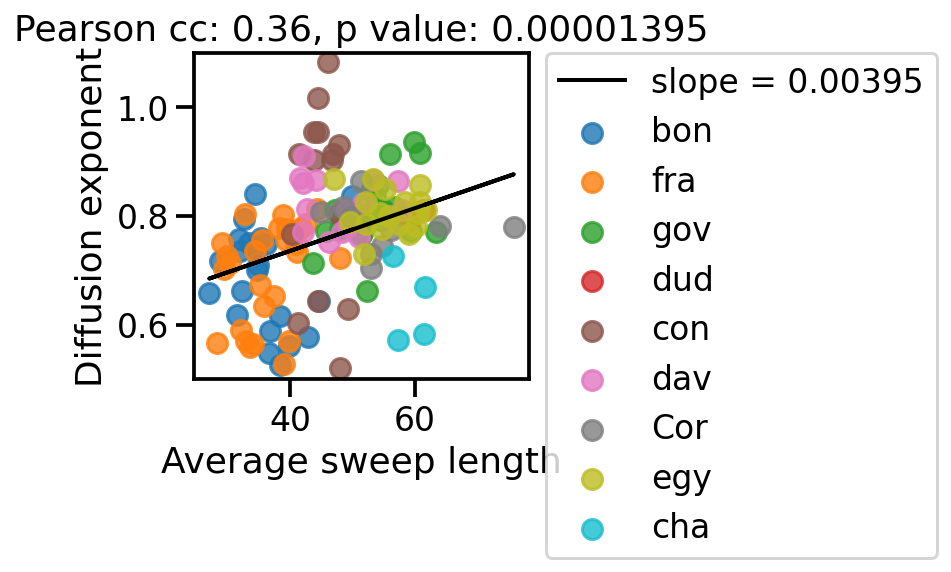

In [9]:
# load real data: ./sweep_replay_correlation_realdata.pkl
# !!! need to run SeeepAwakeReplayCorrelation.ipynb first to generate the pickle file if not exist
with open(
    "../../Processed-Data/sweep_replay_correlation_realdata_persession.pkl", "rb"
) as f:
    (
        animal_names,
        all_sweep_len_peranimal,
        all_sweep_amp_peranimal,
        all_sweep_ahead_peranimal,
        all_sweep_behind_peranimal,
        all_exponent_peranimal,
        all_ave_activespeed_peranimal,
    ) = pickle.load(f)

# put them in a dictionary with animal names as keys
colors = plt.cm.get_cmap("tab10", len(animal_names))
color_dict = {}
for i, name in enumerate(animal_names):
    color_dict[name] = colors(i)

plt.figure(figsize=(3, 3))
for name in animal_names:
    plt.scatter(
        np.array(all_sweep_amp_peranimal[name]),
        np.array(all_exponent_peranimal[name]),
        label=name,
        s=100,
        alpha=0.8,
        color=color_dict[name],
    )
all_exp_np = np.concatenate(list(all_exponent_peranimal.values()))
all_sweep_len_np = np.concatenate(list(all_sweep_amp_peranimal.values()))
# add linear fit line to all_exp_np vs all_speed_np
slope, intercept = np.polyfit(all_sweep_len_np, all_exp_np, 1)
plt.plot(
    all_sweep_len_np,
    all_sweep_len_np * slope + intercept,
    "k-",
    label="slope = %.5f" % slope,
    linewidth=2,
)
# pearson test
corr, p = pearsonr(all_sweep_len_np, all_exp_np)
plt.title("Pearson cc: %.2f, p value: %.8f" % (corr, p))
plt.xlabel("Average sweep length")
plt.ylabel("Diffusion exponent")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.ylim([0.5, 1.1])

plt.tight_layout()

### in-animal shuffle across recording day

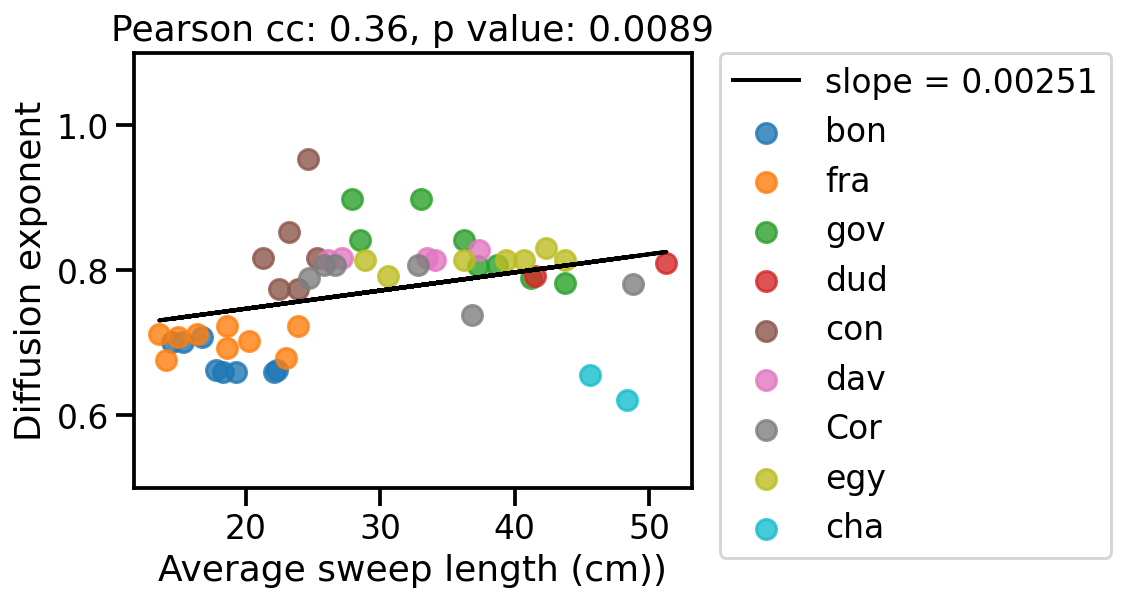

In [32]:
import random

# for each key in all_exponent_perday_concat, shuffle the values in the list
# store the shuffled values in a new dictionary
all_exponent_perday_concat_shuffled = {}
# for key in all_exponent_perday_concat.keys():
#     all_exponent_perday_concat_shuffled[key] = np.random.permutation(
#         all_exponent_perday_concat[key]
#     )
for key in all_exponent_perday_concat.keys():
    exp_key = all_exponent_perday_concat[key]
    exp_key_copy = exp_key.copy()
    # for each elemet in exp_key, replace it with another element in exp_key
    for i in range(len(exp_key_copy)):
        exp_key_except_i = exp_key[:i] + exp_key[i + 1 :]
        exp_key_copy[i] = random.choice(exp_key_except_i)
    all_exponent_perday_concat_shuffled[key] = exp_key_copy

# copy all_sweep_len_perday_concat to a new dictionary
all_sweep_len_perday_concat_shuffled = all_sweep_len_perday_concat.copy()

# plot all_exponent_perday_concat_shuffled against all_sweep_len_perday_concat_shuffled
plt.figure(figsize=(5, 4))
for name in animal_names:
    plt.scatter(
        np.array(all_sweep_len_perday_concat_shuffled[name]),
        np.array(all_exponent_perday_concat_shuffled[name]),
        label=name,
        s=100,
        alpha=0.8,
        color=color_dict[name],
    )
# add linear fit line to the plot using numpy.polyfit
# convert all_sweep_len_perday_concat_shuffled and all_exponent_perday_concat_shuffled to numpy array
exp_np = np.concatenate(list(all_exponent_perday_concat_shuffled.values()))
sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat_shuffled.values()))
slope, intercept = np.polyfit(sweep_len_np, exp_np, 1)
plt.plot(
    sweep_len_np,
    sweep_len_np * slope + intercept,
    "k-",
    label="slope = %.5f" % slope,
    linewidth=2,
)
# pearson test
corr, p = pearsonr(sweep_len_np, exp_np)
plt.title("Pearson cc: %.2f, p value: %.4f" % (corr, p))
plt.xlabel("Average sweep length (cm))")
plt.ylabel("Diffusion exponent")
plt.ylim([0.5, 1.1])
# put the legend outside the plot on the right side
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

In [9]:
def get_corrcoef_and_p(
    all_exponent_perday_concat, all_sweep_len_perday_concat, animal_names
):

    # for each key in all_exponent_perday_concat, shuffle the values in the list
    # store the shuffled values in a new dictionary
    all_exponent_perday_concat_shuffled = {}
    # for key in all_exponent_perday_concat.keys():
    #     all_exponent_perday_concat_shuffled[key] = np.random.permutation(
    #         all_exponent_perday_concat[key]
    #     )
    for key in all_exponent_perday_concat.keys():
        exp_key = all_exponent_perday_concat[key]
        exp_key_copy = exp_key.copy()
        # for each elemet in exp_key, replace it with another element in exp_key
        for i in range(len(exp_key_copy)):
            exp_key_except_i = exp_key[:i] + exp_key[i + 1 :]
            exp_key_copy[i] = random.choice(exp_key_except_i)
        all_exponent_perday_concat_shuffled[key] = exp_key_copy

    # copy all_sweep_len_perday_concat to a new dictionary
    all_sweep_len_perday_concat_shuffled = all_sweep_len_perday_concat.copy()

    exp_np = np.concatenate(list(all_exponent_perday_concat_shuffled.values()))
    sweep_len_np = np.concatenate(list(all_sweep_len_perday_concat_shuffled.values()))

    # pearson test
    corr, p = pearsonr(sweep_len_np, exp_np)

    return corr, p

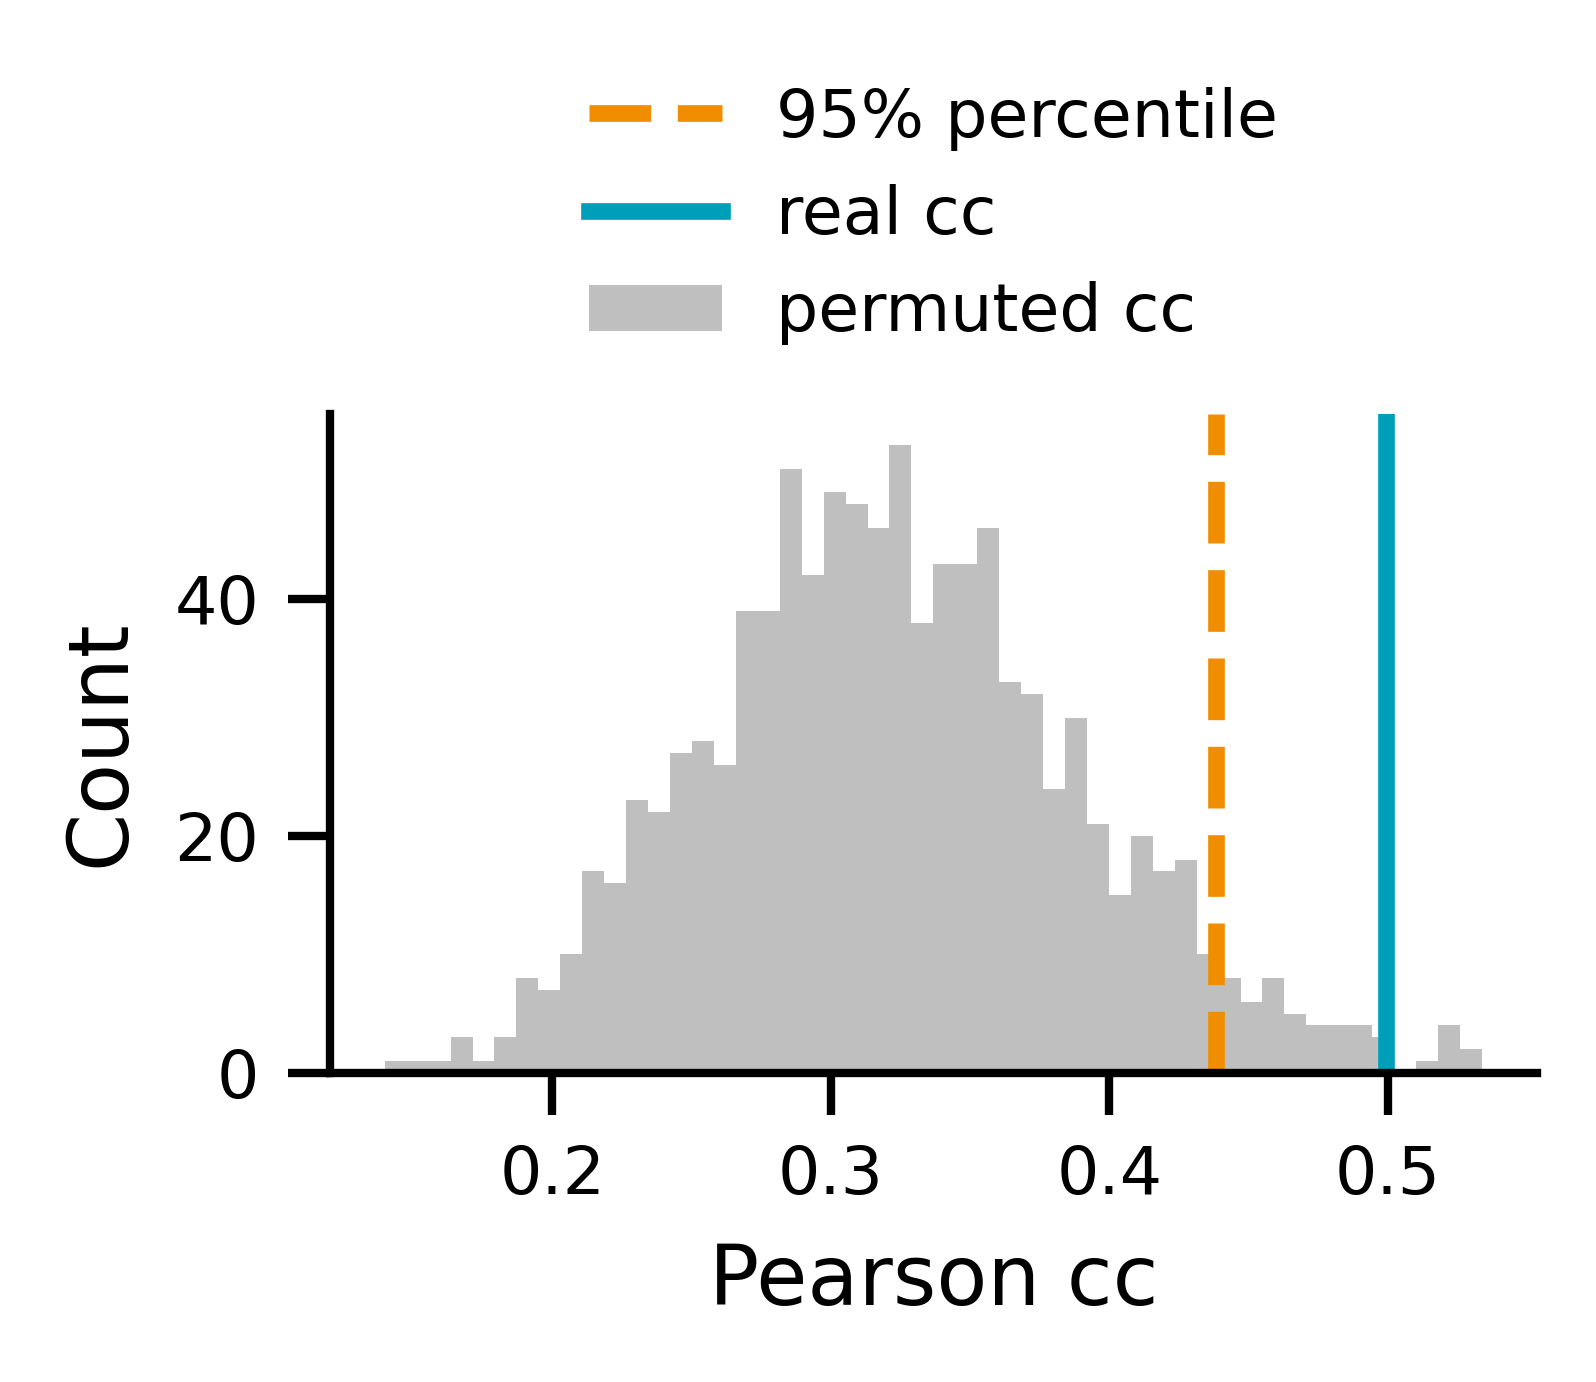

In [20]:
# permute 100 times
corr_list = []
p_list = []

for i in range(1000):
    corr, p = get_corrcoef_and_p(
        all_exponent_perday_concat, all_sweep_len_perday_concat, animal_names
    )
    corr_list.append(corr)
    p_list.append(p)

exp_np = np.concatenate(list(all_exponent_perday_concat.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_perday_concat.values()))
corr_real, p_real = pearsonr(sweep_len_np, exp_np)

# plot the histgoram of corr_list and mark the 95 percentile as a vertical dashed line
# as well as the corr_real as a vertical solid line
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
labelsize = 10
ticksize = 8

ax.hist(
    corr_list, bins=50, color="grey", alpha=0.5, edgecolor="none", label="permuted cc"
)

ax.axvline(
    np.percentile(corr_list, 95),
    color="#F18D00",
    linestyle="dashed",
    linewidth=2,
    label="95% percentile",
)
ax.axvline(corr_real, color="#009FB9", linestyle="solid", linewidth=2, label="real cc")
ax.set_xlabel("Pearson cc", fontsize=labelsize)
ax.set_ylabel("Count", fontsize=labelsize)
# top and right spine should be invisible
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# legend
ax.legend(fontsize=ticksize, frameon=False, loc="center", bbox_to_anchor=(0.5, 1.3))
#
# axis line width 1.0
ax.spines["bottom"].set_linewidth(1.0)
ax.spines["left"].set_linewidth(1.0)
# remove the tick bars on the left and bottom linewidth=1.0
ax.tick_params(axis="both", which="both", length=5, width=1.0)
# set ticks fontsize
ax.tick_params(axis="both", which="major", labelsize=ticksize)

plt.tight_layout()
# save fig
savedir = "/home/zilong/Desktop/replay_trajectory_paper/Processed-Data/Paper_figures/"
fig.savefig(
    savedir + "FigSI_sweep_replay_correlation_acrossday_shuffle.pdf",
)

### in-animal shuffle across recording session

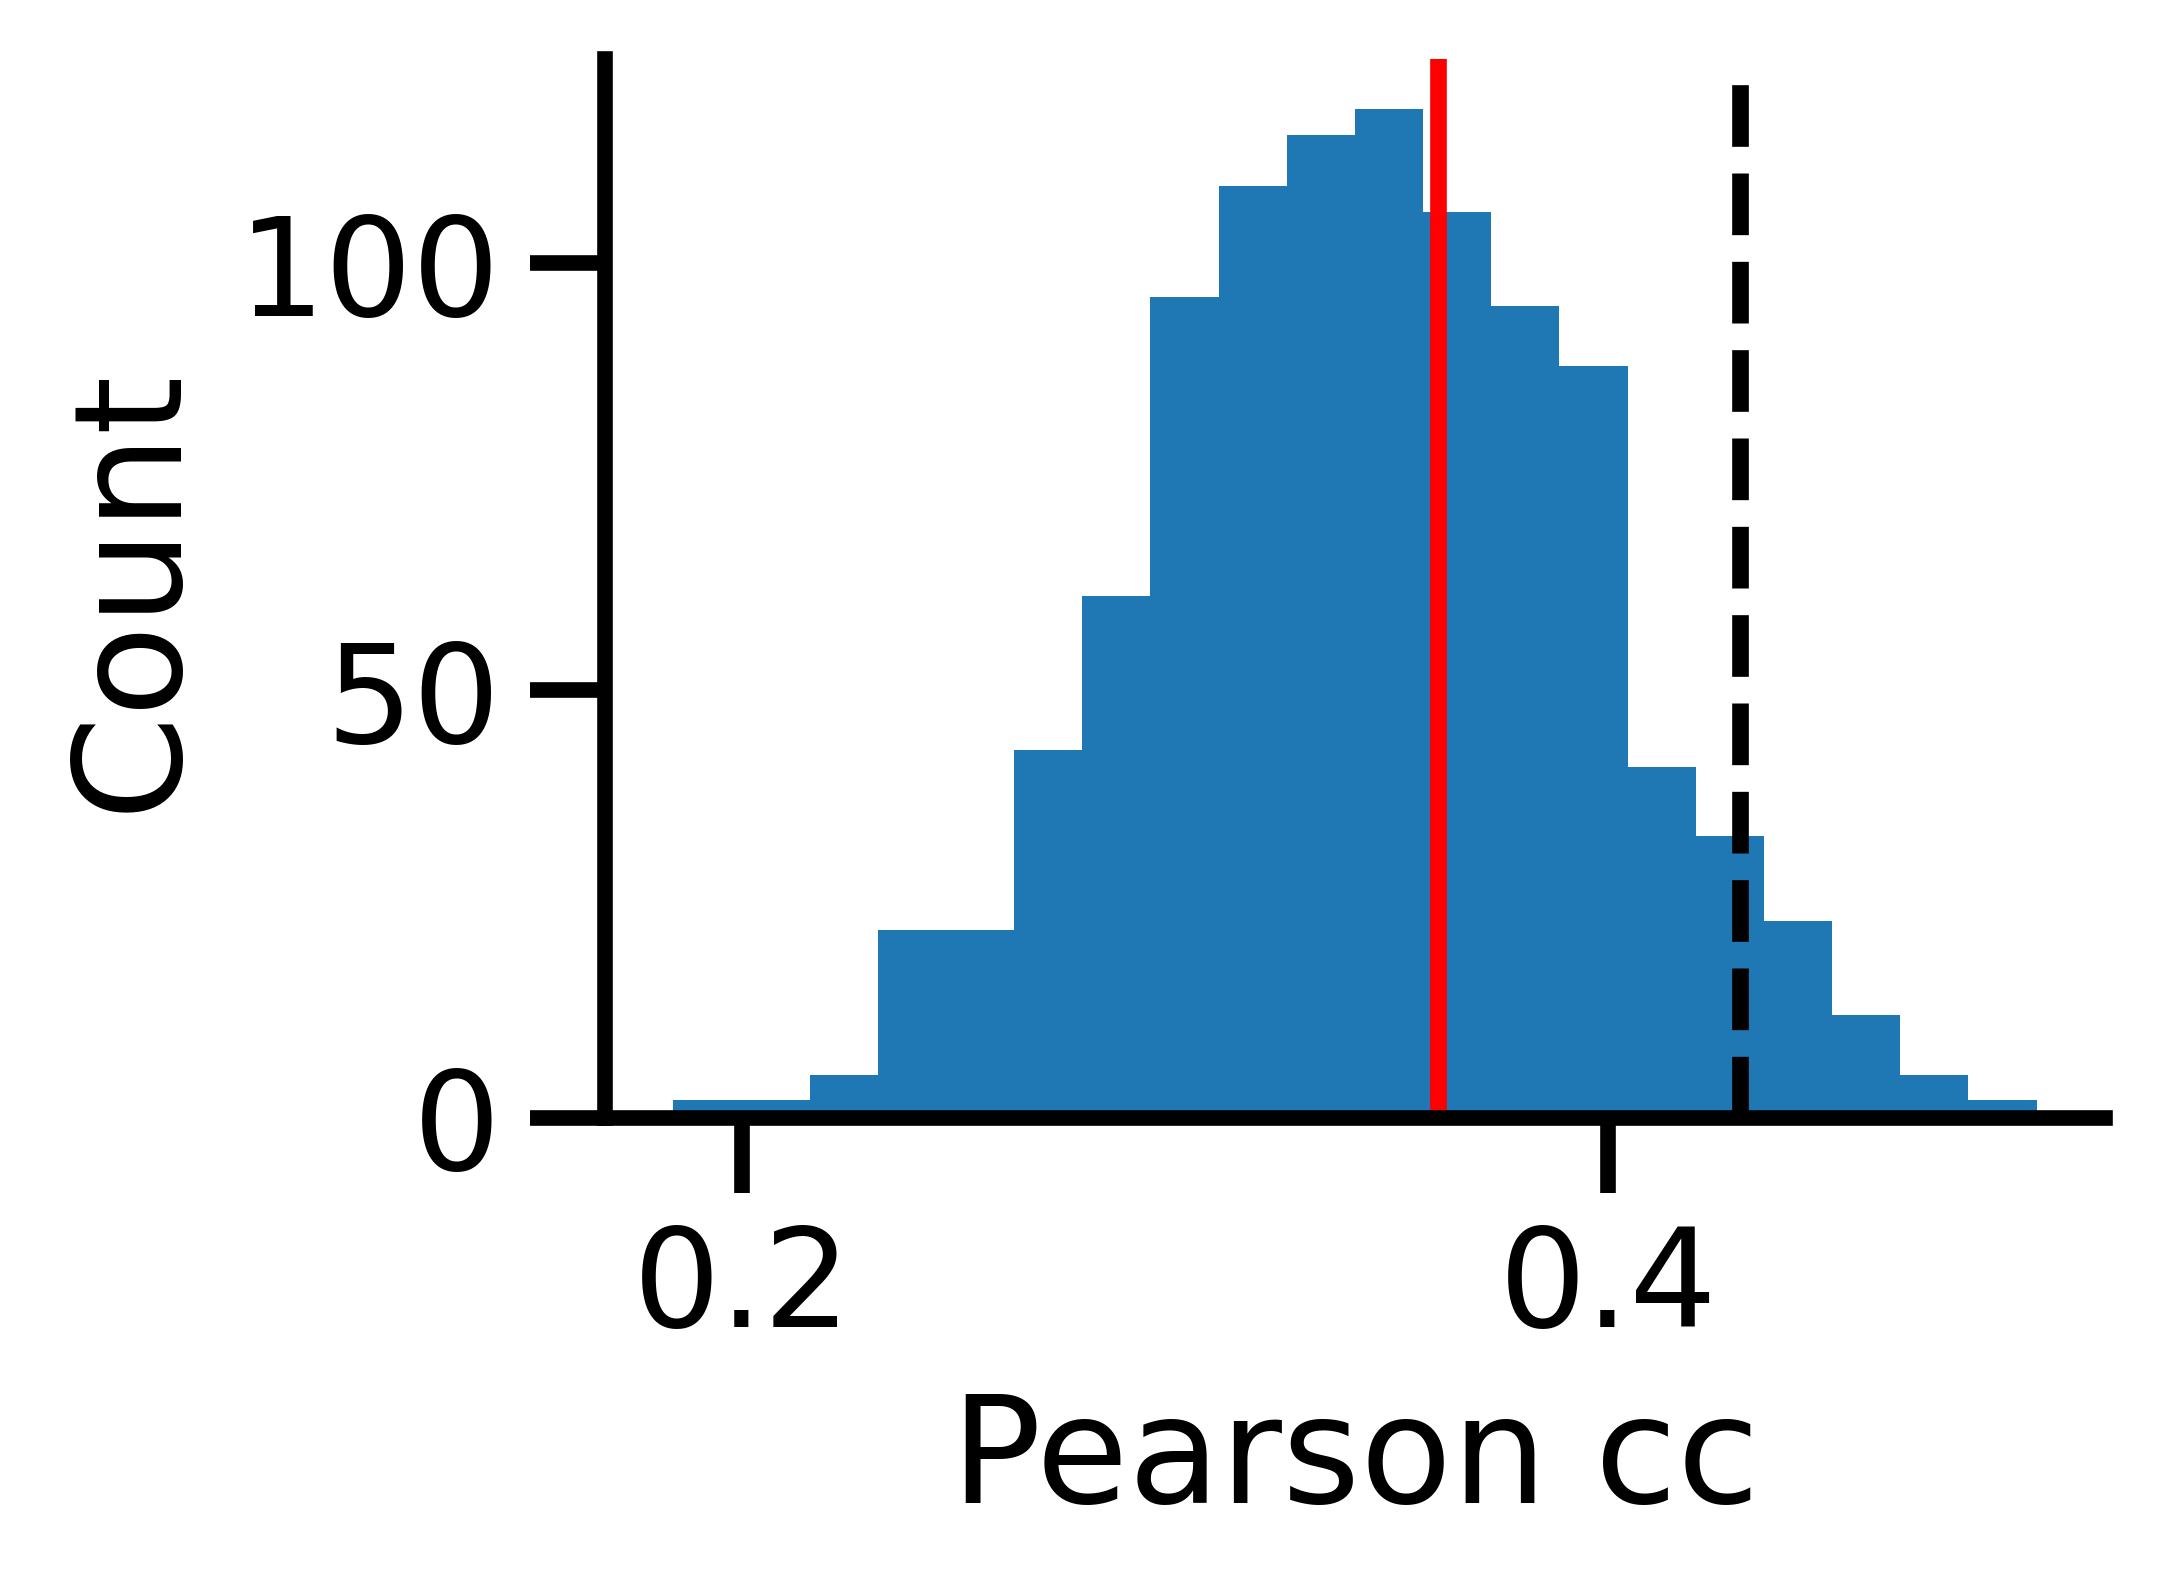

In [61]:
# permute 100 times
corr_list = []
p_list = []

for i in range(1000):
    corr, p = get_corrcoef_and_p(
        all_exponent_peranimal, all_sweep_amp_peranimal, animal_names
    )
    corr_list.append(corr)
    p_list.append(p)

exp_np = np.concatenate(list(all_exponent_peranimal.values()))
sweep_len_np = np.concatenate(list(all_sweep_amp_peranimal.values()))
corr_real, p_real = pearsonr(sweep_len_np, exp_np)

# plot the histgoram of corr_list and mark the 95 percentile as a vertical dashed line
# as well as the corr_real as a vertical solid line
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)
ax.hist(corr_list, bins=20)
ax.axvline(np.percentile(corr_list, 95), color="k", linestyle="dashed", linewidth=2)
ax.axvline(corr_real, color="red", linestyle="solid", linewidth=2)
ax.set_xlabel("Pearson cc")
ax.set_ylabel("Count")
# top and right spine should be invisible
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()